In [1]:
from pandas_datareader import wb
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import scipy.stats as stats

/opt/conda/lib/python3.10/site-packages/pandas_datareader/wb.py:592: UserWarning: Non-standard ISO country codes: WLD
  warnings.warn(


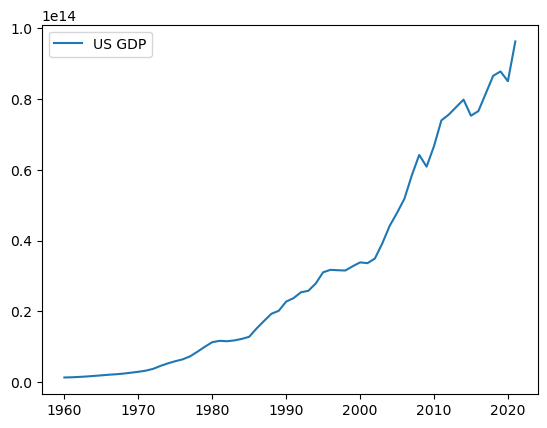

In [2]:
gdp_data = wb.download(indicator="NY.GDP.MKTP.CD", country="WLD", start="1960", end="2021")
time = np.arange(1960,2022)
gdp = gdp_data.iloc[:,0].astype("float").to_numpy()
gdp = np.flip(gdp)
plt.plot(time, gdp, label="US GDP")
plt.legend()
plt.show()

We can apply a log of any base to this equation to make it a linear relationship. Note that this linear relationship will be between log(GDP) and k.

I will use the natural logarithm.

So,

$log(GDP_k) = log(GDP_0 (1+r)^k)$

<==>

$log(GDP_k) = log(GDP_0) + k log(1+r)$

In [3]:
gdp_log = np.log(gdp)
k = time - 1960

In [4]:
output = linregress(k, gdp_log)
slope, intercept, r_2 = output[0:3]

In [5]:
def LinearRegression(x, slope, intercept):
    return x*slope + intercept

In [6]:
l1 = lambda x: LinearRegression(x, slope, intercept)

In [7]:
predictions = l1(k)

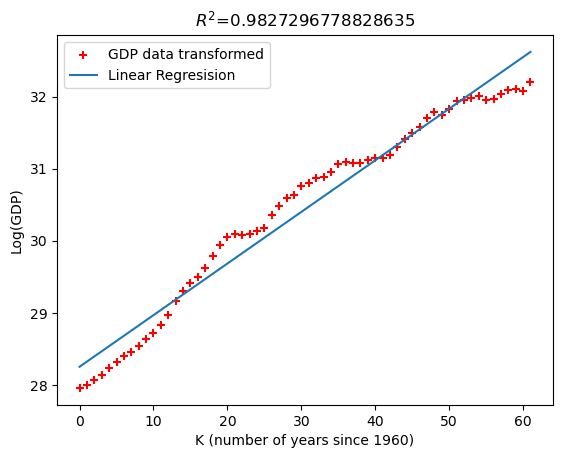

In [8]:
plt.scatter(k, gdp_log,c="r",marker="+", label="GDP data transformed")
plt.plot(k, predictions, label="Linear Regresision")
plt.legend()
plt.title(f"$R^2$={r_2}")
plt.ylabel("Log(GDP)")
plt.xlabel("K (number of years since 1960)")
plt.show()

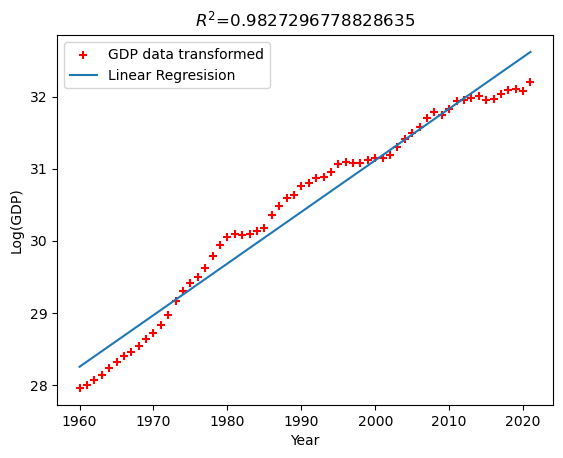

In [9]:
plt.scatter(time, gdp_log,c="r",marker="+", label="GDP data transformed")
plt.plot(time, predictions, label="Linear Regresision")
plt.legend()
plt.title(f"$R^2$={r_2}")
plt.ylabel("Log(GDP)")
plt.xlabel("Year")
plt.show()

In [10]:
residuals = predictions - gdp_log

In [11]:
print("mean of residuals: ",residuals.mean())
print("std of residuals: ",residuals.std())

mean of residuals:  -4.0111283470328235e-16
std of residuals:  0.24107101576840817


In [12]:
stats.kstest(residuals, stats.norm(0,residuals.std()).cdf)

KstestResult(statistic=0.12982260821736014, pvalue=0.22644562327630569)

Clearly from the result of the KS test above, the pvalue of 0.22644562327630569 is much greater than of our thresholds (Which in this case is a 2-sided test so $\frac{1-\alpha}{2} = 0.005$).

So, we say that there is insufficient evidence to reject $H_0$. Meaning, there is evidence to suggest that the residuals are sampled from a normal distribution with mean 0 and standard deviation $\hat{\sigma}$.

In [13]:
actual_predictions = np.exp(predictions)

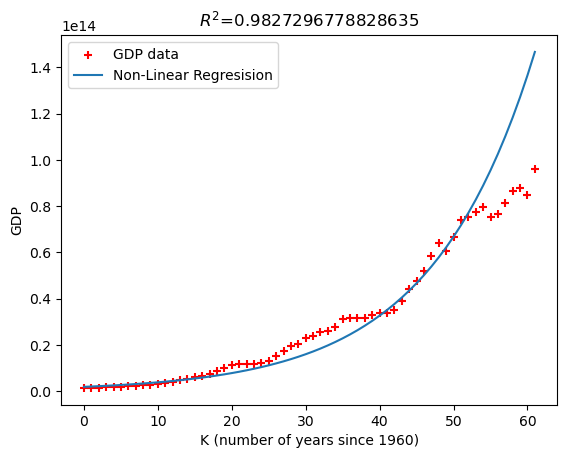

In [14]:
plt.scatter(k, gdp,c="r",marker="+", label="GDP data")
plt.plot(k, actual_predictions, label="Non-Linear Regresision")
plt.legend()
plt.title(f"$R^2$={r_2}")
plt.ylabel("GDP")
plt.xlabel("K (number of years since 1960)")
plt.show()

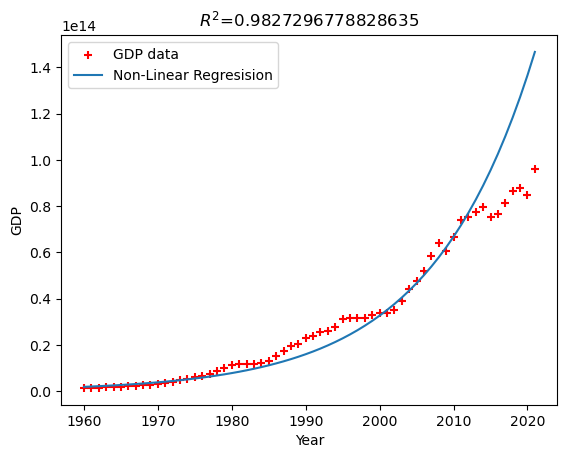

In [15]:
plt.scatter(time, gdp,c="r",marker="+", label="GDP data")
plt.plot(time, actual_predictions, label="Non-Linear Regresision")
plt.legend()
plt.title(f"$R^2$={r_2}")
plt.ylabel("GDP")
plt.xlabel("Year")
plt.show()

In our Linear regression, the relationship between the slope of the regression line and the growth rate is:

$slope = log(1 + r)$

In our non-Linear regression, the relationship between the slope of the regression line and the growth rate is:

$e^{slope} = 1 + r$

In [16]:
r = np.exp(slope) - 1
print("Long-term growth rate: ",r)

Long-term growth rate:  0.07416175185774487


Since 2015, it seems that the world's GDP is slowing down. Before then, the model was sufficiently able to predict the world's GDP but now the model overestimates the actual GDP. As such, we can infer that the world's GDP is less than the model predicts and as such we can say it is slowing down compared to this models predictions.

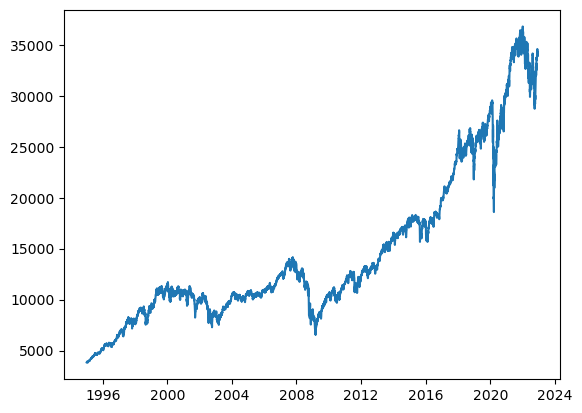

In [17]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt

data = web.DataReader("^DJI", "yahoo", start="1995-01-01", end="2022-12-05")
data = data.reset_index()
dates = data["Date"]
dow = data["Close"].to_numpy()
plt.plot(dates,dow)
plt.show()

In [18]:
lags = [1,2,3,5,10,15,20,30]

def Covariance(x, y):
    x_bar = x.mean()
    y_bar = y.mean()
    return sum([(x[i]-x_bar)*(y[i]-y_bar) for i in range(len(y))])/(len(y)-1)

def Correlation(x, y):
    return Covariance(x, y)/(x.std(ddof=1)*y.std(ddof=1))

In [19]:
window_size = 60
corrs = []
for lag in lags:
    corr = []
    for i in range(len(dow)-window_size-lag+1):
        corr.append(Correlation(dow[i:i+window_size], dow[i+lag:i+lag+window_size]))
    corrs.append(corr)

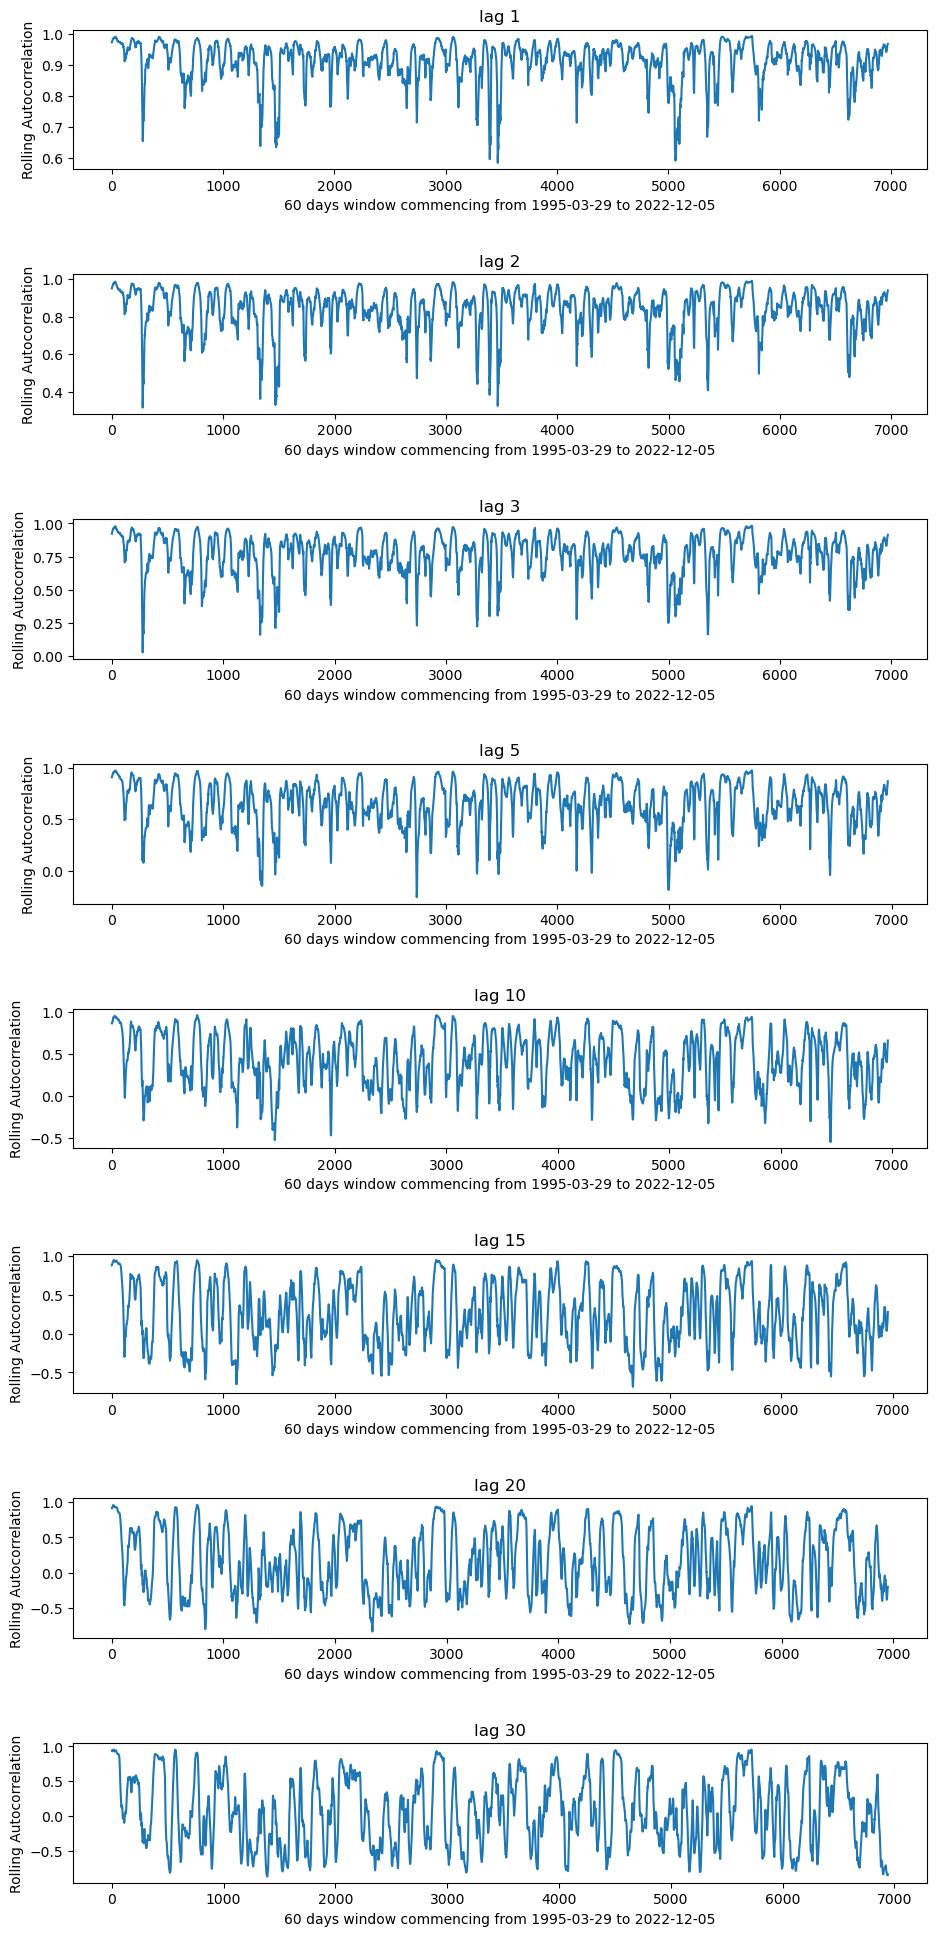

In [20]:
fig,axs = plt.subplots(8, figsize=(10,20))
for i in range(len(lags)):
    axs[i].plot(corrs[i])
    axs[i].set_title(f"lag {lags[i]}")
    axs[i].set_xlabel("60 days window commencing from 1995-03-29 to 2022-12-05")
    axs[i].set_ylabel("Rolling Autocorrelation")
fig.tight_layout(pad=3)
fig.show()

In [21]:
mean_autocorr = [np.array(i).mean() for i in corrs]

Text(0, 0.5, 'Average Autocorrelation')

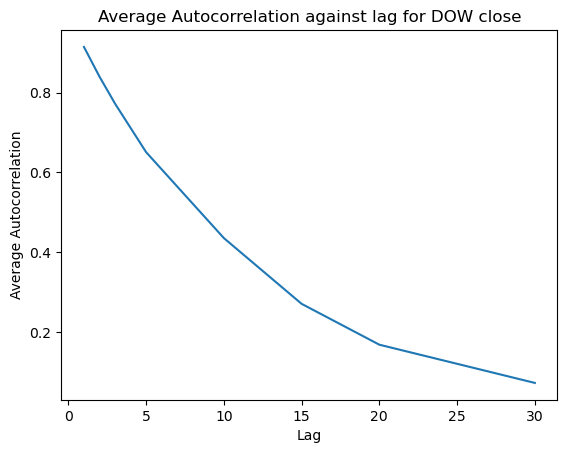

In [22]:
plt.plot(lags,mean_autocorr)
plt.title("Average Autocorrelation against lag for DOW close")
plt.xlabel("Lag")
plt.ylabel("Average Autocorrelation")

We observe that as the lag increases the average autocorrelation decreases. This means that data from 30 days ago is more relevant than data from 60 days ago (I.e., greater correlation).

This suggests that the DOW Jones is not a white noise processes as a white noise processes has a autocorrelation of 0 at all lags except lag 0.

A better model could be an ARMA(1,1) process.

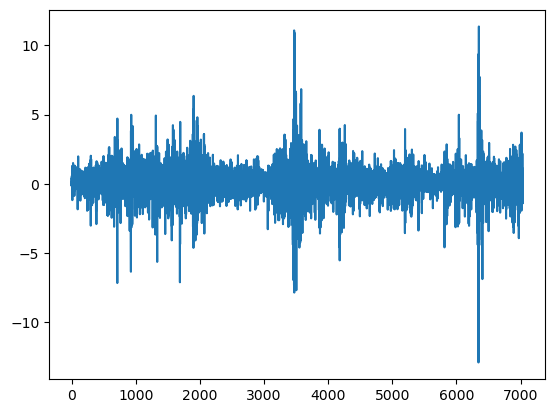

In [23]:
percentage_returns = []
for i in range(1,len(dow)):
    percentage_returns.append(100*((dow[i]/dow[i-1])-1))
percentage_returns = np.array(percentage_returns)
    
plt.plot(percentage_returns)

In [24]:
window_size = 60
corrs = []
for lag in lags:
    corr = []
    for i in range(len(percentage_returns)-window_size-lag+1):
        corr.append(Correlation(percentage_returns[i:i+window_size], percentage_returns[i+lag:i+lag+window_size]))
    corrs.append(corr)

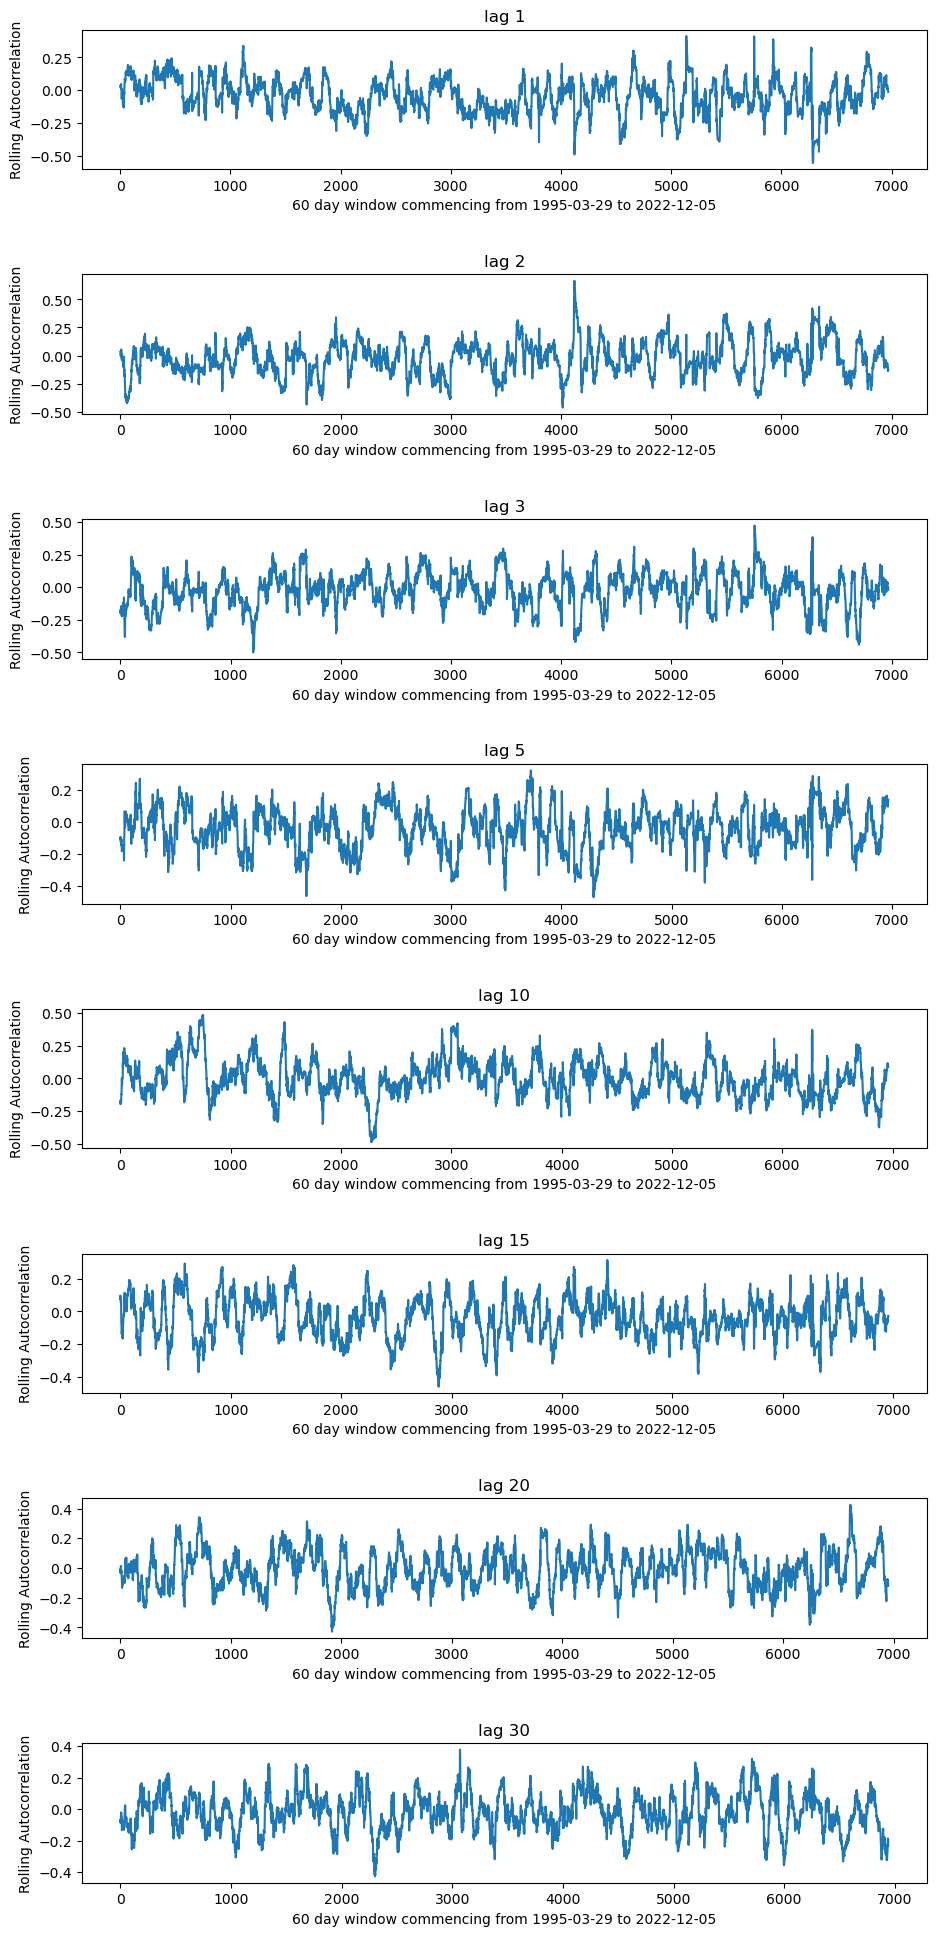

In [25]:
fig,axs = plt.subplots(8, figsize=(10,20))
for i in range(len(lags)):
    axs[i].plot(corrs[i])
    axs[i].set_title(f"lag {lags[i]}")
    axs[i].set_xlabel("60 day window commencing from 1995-03-29 to 2022-12-05")
    axs[i].set_ylabel("Rolling Autocorrelation")
fig.tight_layout(pad=3)
fig.show()

In [26]:
mean_autocorr = [np.array(i).mean() for i in corrs]

Text(0, 0.5, 'Average Autocorrelation')

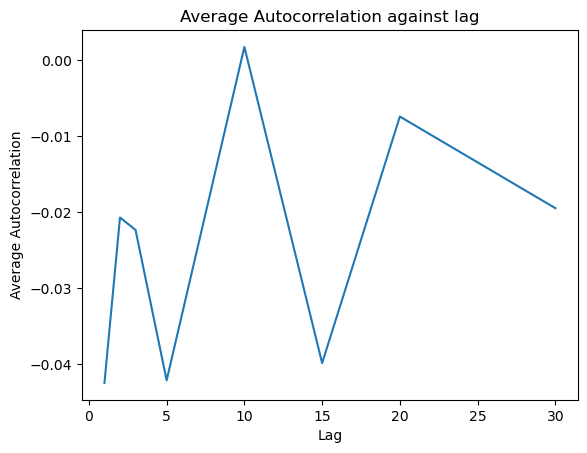

In [27]:
plt.plot(lags,mean_autocorr)
plt.title("Average Autocorrelation against lag")
plt.xlabel("Lag")
plt.ylabel("Average Autocorrelation")

We observe that the autocorrelation is very small and close to 0 suggesting there is no correlation.

The autocorrelation for the Daily returns of the DOW Jones data suggests that this is a white noise process due to it hovering around 0 for all the lags.